# Summary
This notebook was made to experiment with some feature engineering, encoding of categorical features, and model testing. More specifically the following was tried:
* preprocess data (fill NaNs, drop-duplicates, select most important columns)
* Extract year and month from date-recorded
* Replace low frequent categories with the term 'other'
* Test simple log-reg model with a few features to get some base-line metrics.
* Test Random-Forest, XGBoost, and LightGBM with all features.
* Compare metrics.
* Inspect feature importance. 

In [31]:
import pandas as pd
import numpy as np
pd.options.plotting.backend = "plotly"
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import sklearn
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

## Preprocess

In [39]:
X_original.construction_year.nunique()

55

In [48]:
X_original = pd.read_csv('../water_pump_2/water_pump_set.csv')
y_original = pd.read_csv('../water_pump_2/water_pump_labels.csv')

drop_these = [ 'wpt_name', 'num_private', 'subvillage', 'region', 'scheme_name',
              'extraction_type', 'extraction_type_group',
              'management', 'payment', 'water_quality', 'quantity', 'source',
              'waterpoint_type', 'population', 'recorded_by']

## What to do with population = 0 ?
X = X_original.drop(drop_these, axis = 1)

# Fill NaN with unknown
X = X.fillna('unknown')

# Extract year and month from date
X['date_recorded'] = pd.to_datetime(X.date_recorded)
X['year'] = X['date_recorded'].dt.year
X['month'] = X['date_recorded'].dt.month
X.year = X.year - X.year.min()
X = X.drop('date_recorded', axis = 1)

# Drop duplicates (why are there duplicates?)
X = X.drop_duplicates()

# Change some numeric features to categorical features
X['region_code'] = X['region_code'].astype('str')
X['district_code'] = X['district_code'].astype('str')
X['month'] = X['month'].astype('str')

# Make sure some features are the correct type
type_dict = {'amount_tsh':'float64',
             'gps_height':'float64',
             'longitude':'float64',
             'latitude':'float64',
             'public_meeting':'str',
             'permit':'str',
             'construction_year':'str'
            }
X = X.astype(dtype = type_dict)

## Clean up unrealistic values
X = X[X.longitude!=0]
X = X[X.latitude!=0]

# Make sure that the target matches the input
y = pd.merge(X, y_original, how = 'left', left_on = 'id', right_on  = 'id')
y = y['status_group']
target_map = {'functional': 0, 'non functional': 1, 'functional needs repair': 2}
y = y.map(lambda x: target_map[x])
X = X.drop('id', axis = 1)

In [49]:
X.select_dtypes(exclude='number').describe()

,funder,installer,basin,region_code,district_code,lga,ward,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,month
count,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588
unique,1859,2113,9,27,20,124,2033,3,13,3,55,7,5,7,6,5,7,3,6,12
top,Government Of Tanzania,DWE,Pangani,11,1,Njombe,Igosi,True,VWC,True,0,gravity,user-group,never pay,good,enough,spring,groundwater,communal standpipe,3
freq,8842,16255,8940,5297,11146,2503,307,49737,36143,38100,18897,26696,50767,24380,49431,32260,17006,44204,34334,17932


In [50]:
remove_low_freq = ['funder', 'installer', 'ward']
for col in remove_low_freq:
    X.loc[X[col].value_counts()[X[col]].values < 20, col] = "other"

In [51]:
X.select_dtypes(exclude='number').describe()

,funder,installer,basin,region_code,district_code,lga,ward,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,month
count,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588,57588
unique,267,268,9,27,20,124,1048,3,13,3,55,7,5,7,6,5,7,3,6,12
top,Government Of Tanzania,DWE,Pangani,11,1,Njombe,other,True,VWC,True,0,gravity,user-group,never pay,good,enough,spring,groundwater,communal standpipe,3
freq,8842,16255,8940,5297,11146,2503,9922,49737,36143,38100,18897,26696,50767,24380,49431,32260,17006,44204,34334,17932


#### Does adding construction year help? Does not improve accuracy much it seems. 

In [60]:
X = X.replace({'construction_year':'0'}, np.nan)
X['no_construction'] = X['construction_year'].apply(lambda x: x != x)

## One hot encode and perform Log Reg

In [9]:
n_uni = X.select_dtypes(exclude='number').nunique().sort_values()
cols_to_keep = n_uni[n_uni.values<20].index.tolist()

In [10]:
X_cat = X[cols_to_keep]
X_cat_one_hot = pd.get_dummies(X_cat)

X_train, X_test, y_train, y_test = train_test_split( X_cat_one_hot, y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train.values, y_train.values)

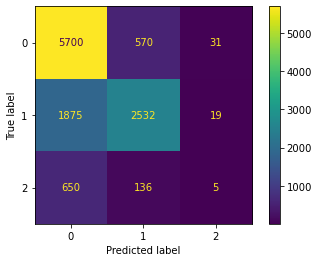

In [14]:
plot_confusion_matrix(clf, X_test, y_test)

In [17]:
y_pred = clf.predict(X_test)
target_names = target_map.keys()
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.69      0.90      0.78      6301
         non functional       0.78      0.57      0.66      4426
functional needs repair       0.09      0.01      0.01       791

               accuracy                           0.72     11518
              macro avg       0.52      0.49      0.49     11518
           weighted avg       0.69      0.72      0.68     11518



## Random Forest with all variables


#### Ordinal

In [62]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

In [63]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [80]:
model.predict_proba(X_test.iloc[0:1])[0]

array([0.03, 0.95, 0.02])

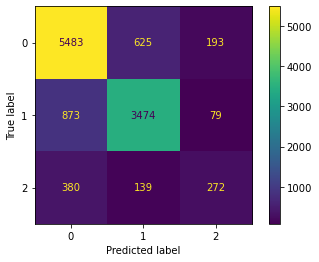

In [64]:
X_test = encoder.transform(X_test)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)

In [65]:
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6301
         non functional       0.82      0.78      0.80      4426
functional needs repair       0.50      0.34      0.41       791

               accuracy                           0.80     11518
              macro avg       0.71      0.67      0.68     11518
           weighted avg       0.79      0.80      0.80     11518



## One hot

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

encoder = ce.OneHotEncoder()
X_train = encoder.fit_transform(X_train)

In [24]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

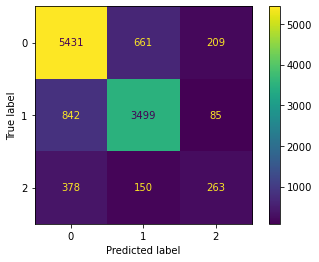

In [25]:
X_test = encoder.transform(X_test)
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)

In [26]:
print(classification_report(y_test, y_pred, target_names=target_map.keys()))

                         precision    recall  f1-score   support

             functional       0.82      0.86      0.84      6301
         non functional       0.81      0.79      0.80      4426
functional needs repair       0.47      0.33      0.39       791

               accuracy                           0.80     11518
              macro avg       0.70      0.66      0.68     11518
           weighted avg       0.79      0.80      0.79     11518



## XGBoost

In [28]:
# modelxgb = XGBClassifier()
# modelxgb.fit(X_train, y_train)

In [30]:
# y_pred = modelxgb.predict(X_test)

In [29]:
# print(classification_report(y_test, y_pred, target_names=target_names))

## LightGBM

In [72]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [70]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.76      0.92      0.83      6301
         non functional       0.84      0.69      0.76      4426
functional needs repair       0.64      0.19      0.29       791

               accuracy                           0.78     11518
              macro avg       0.75      0.60      0.63     11518
           weighted avg       0.78      0.78      0.77     11518



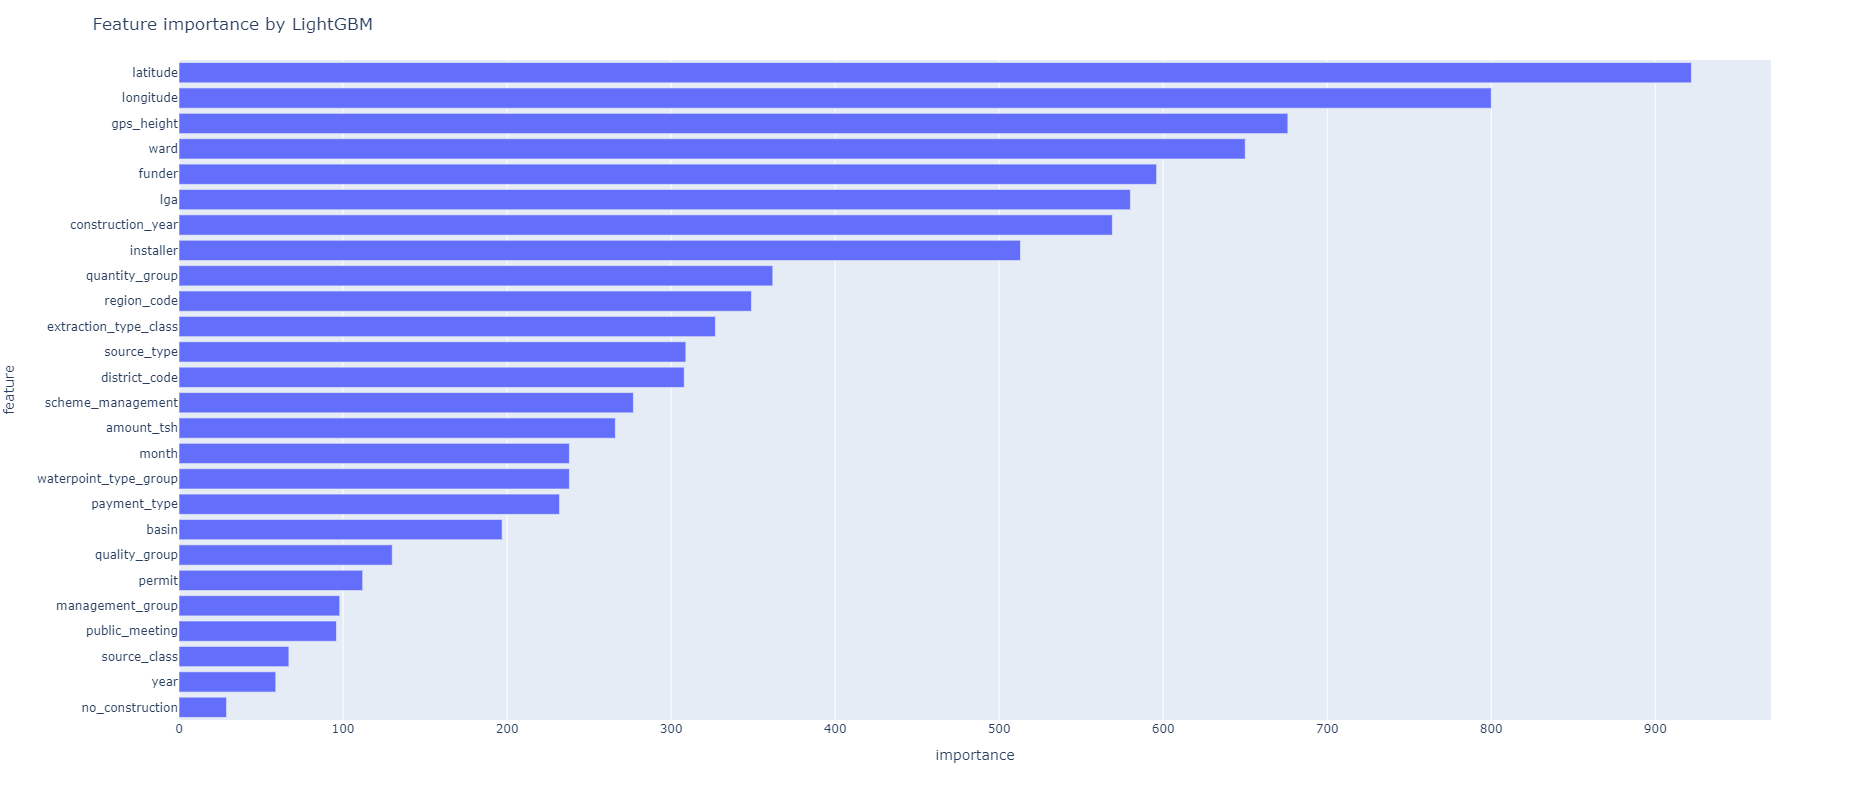

In [68]:
feature_importance = pd.DataFrame({'feature':X_train.columns, 'importance': clf.feature_importances_})
feature_importance = feature_importance.sort_values('importance')
fig = feature_importance.plot.bar(y = 'feature',x = 'importance', orientation = 'h')
fig.update_layout(title='Feature importance by LightGBM', height = 800, width = 600)
fig.show()